In [1]:
%load_ext autoreload
%autoreload 2
import sys
repo_dir = '/home/labs/amit/noamsh/repos/MM_2023'
sys.path.append(repo_dir)

In [96]:
from pathlib import Path
from omegaconf import OmegaConf
import os

import pandas as pd
import numpy as np

import anndata as ad
import pyreadr
import gseapy as gp
import scanpy as sc

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import matplotlib.colors as mcolors

from data_loading.utils import load_dataframe_from_file
from io_utils import generate_path_in_output_dir

## plats

In [94]:
pal_cytorisk = {'Standard Risk':(0.9427942677547513, 0.942825384792593, 0.9519953287278279),
                'Single Hit':(0.6285295118365009, 0.6285502565283954, 0.9679968858185519),
                '2+ Hits':(0.0, 0.0, 1.0),
                'NA':'#CCCCCC'}

disease_categories = ann.Disease.unique()#.cat.categories
pal_disease = {disease: color for disease, color in zip(disease_categories, sns.color_palette("tab10", len(disease_categories)))}

pal_binary  = {'Yes':'#000000', 'No':'#FFFFFF', 'NA':'#CCCCCC'}
pal_pcann = {'Malignant':'#D33E8B', 
             'Healthy':'#B1F3F7', 'Healthy_Like':'#96CAD8'}

pal_architype = {f'{arch}': color for arch, color in zip(ann['architype'].unique(), sns.color_palette("Accent", len(ann['architype'].unique())))}
pal_architype['NA'] = '#CCCCCC'

pal_method = {'SPID':'#2A67C4',
              'MARS':'#2AC42F'}

pal_tissue = {'Blood':'#DB3838',
              'BM':'#3896DB',
              'EMD':'#38DB58',
              'NA':'##CCCCCC'
              }

pal_trial = {f'{arch}': color for arch, color in zip(ann['Clinical.Trial'].unique(), sns.color_palette("Dark2", len(ann['Clinical.Trial'].unique())))}
pal_trial['NA'] = '#CCCCCC'

pal_time = {f'{arch}': color for arch, color in zip(ann['Time'].unique(), sns.color_palette("Set3", len(ann['Time'].unique())))}
pal_time['NA'] = '#CCCCCC'

pal_iss = {'NA':'#CCCCCC',
           '1.0':'#D1EB42',
           '2.0':'#DBC738',
           '3.0':'#DB8238'}


## validate within our dataset

### per archytype geneset

In [49]:
path_sh = '/home/labs/amit/shuangyi/Project_MM3/Atlas/scvi_diff/z_v4_gene_clus.Rds'
result = pyreadr.read_r(path_sh)[None]
genesets_arch_dict = {}
for clus_new_value in result['clus_new'].astype(str).unique():
    genesets_arch_dict[clus_new_value] = result[result['clus_new'].astype(str) == clus_new_value]['Gene'].tolist()

{arch: f"{len(genes)} genes" for arch, genes in genesets_arch_dict.items()}

{'1.0': '96 genes',
 '2.0': '145 genes',
 '3.0': '90 genes',
 '4.0': '114 genes',
 '5.0': '77 genes',
 '6.0': '113 genes',
 '7.0': '138 genes',
 '8.0': '211 genes'}

### PC high genes (with nalignancy)

In [6]:
data_dir = "/home/labs/amit/noamsh/repos/MM_2023/outputs"
path = Path(data_dir , "adata_with_scvi_annot_pred_data_v_20240619_ts_2024-06-28_only_pc_annotated_filtered_md_v_2024-07-21.h5ad")
adata_pc = sc.read_h5ad(path)
adata_pc

AnnData object with n_obs × n_vars = 163913 × 3862
    obs: 'Amp.Batch.ID', 'Seq.Batch.ID', 'Batch.Set.ID', 'Included', 'Tissue', 'Gating', 'Total.PC', 'Total.NonPC', 'Initial.Code', 'Disease', 'Time', 'Project', 'Cohort', 'Weizmann.Code', 'Hospital.Code', 'Clinical.Data', 'Biopsy.Sequence', 'Previous.Hospital.Code', 'Method', 'cID', 'super_Population', 'Populations', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'Predicted', 'count_of_PC_in_neighborhood', 'count_of_CD45_in_neighborhood', 'pc_with_tme_environment', 'number_of_diffrent_patients_in_nighborhood', 'MGUS', 'SMM', 'NDMM', 'pc_annotation', 'Healthy', 'one_pateint_in_nighborhood', 'small_pateint_in_nighborhood', 'log_total_counts', 'noisy_malignant', 'noisy_malignant_by_umi', 'Clinical.Trial'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'Disease_colors', 'Healthy_colors', 

In [18]:
adata_pp = sc.read_h5ad(Path(data_dir , "raw_adata_data_v_20240619_md_v_2024-07-21.h5ad"))
adata_pp

AnnData object with n_obs × n_vars = 973824 × 57874
    obs: 'Amp.Batch.ID', 'Seq.Batch.ID', 'Batch.Set.ID', 'Included', 'Tissue', 'Gating', 'Total.PC', 'Total.NonPC', 'Initial.Code', 'Disease', 'Time', 'Project', 'Cohort', 'Weizmann.Code', 'Hospital.Code', 'Clinical.Data', 'Biopsy.Sequence', 'Previous.Hospital.Code', 'Method', 'Clinical.Trial'

In [23]:
adata_pp_pc = adata_raw[adata_pc.obs_names, :]
adata_pp_pc

View of AnnData object with n_obs × n_vars = 163913 × 57874
    obs: 'Amp.Batch.ID', 'Seq.Batch.ID', 'Batch.Set.ID', 'Included', 'Tissue', 'Gating', 'Total.PC', 'Total.NonPC', 'Initial.Code', 'Disease', 'Time', 'Project', 'Cohort', 'Weizmann.Code', 'Hospital.Code', 'Clinical.Data', 'Biopsy.Sequence', 'Previous.Hospital.Code', 'Method', 'Clinical.Trial'

In [24]:
sc.pp.normalize_total(adata_pp_pc, target_sum=1e4)
sc.pp.log1p(adata_pp_pc)

/home/labs/amit/noamsh/.local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [59]:
sc.pp.highly_variable_genes(adata_pp_pc, min_mean=0.1, max_mean=8, min_disp=0)
# sc.pl.highly_variable_genes(adata_pp_pc)

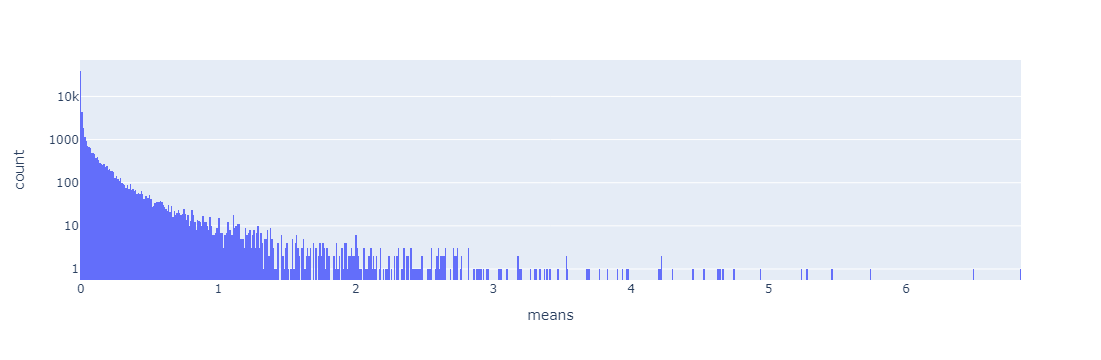

1588


In [60]:
import plotly.express as px
from plotly import graph_objects as go

fig = px.histogram(pd.DataFrame(adata_pp_pc.var["means"]), x="means", log_y=True)
# fig = go.Figure(data=[go.Histogram(y=adata_pp_pc.var["means"] ,cumulative_enabled=True)])
fig.show()
print((adata_pp_pc.var["means"] > 0.5).sum())

In [61]:
pc_high_genes = list(adata_pp_pc[:, adata_pp_pc.var["means"] > 0.5].var_names)

In [62]:
new_genesets_arch_dict = {arch: set(genes).intersection(pc_high_genes) for arch, genes in genesets_arch_dict.items()}
{arch: f"{len(genes)} genes" for arch, genes in new_genesets_arch_dict.items()}

{'1.0': '74 genes',
 '2.0': '72 genes',
 '3.0': '61 genes',
 '4.0': '43 genes',
 '5.0': '54 genes',
 '6.0': '80 genes',
 '7.0': '74 genes',
 '8.0': '141 genes'}

#### check if intersection with known is same

In [63]:
genesets_public_dict = {}
#https://www.nature.com/articles/leu201677
genesets_public_dict['Hh_signature'] = ['IHH', 'DHH', 'SMO', 'PTCH1', 'PTCH2', 'SUFU', 'GLI1', 'GLI2', 'GLI3']
# no SHH gene (downregulated)
#PMID: 16728703
genesets_public_dict['PI_signature'] = ['OP2A', 'BIRC5', 'CCNB2', 'NEK2', 'ANAPC7', 'STK6', 'BUB1', 'CDC2', 'C10orf3', 'ASPM', 'CDCA1']
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2730509/ (old 2007 but anyway)
genesets_public_dict['NFkB_signature'] = ['BIRC3', 'TNFAIP3', 'NFKB2', 'IL2RG', 'NFKBIE', 'RELB', 'NFKBIA', 
'CD74', 'PLEK', 'MALT1', 'WNT10A']


In [64]:
data_path = '/home/labs/amit/annaku/repos/MM_2024_AK/data/'


# MS 2006 
genesets_ms_dict = {}
for filename in os.listdir(data_path+'/genesets/'):
    name = filename.split('_')[3] + '_' + filename.split('_')[4].split('.')[0]
    genesets_ms_dict[name] = gp.read_gmt(path = data_path+'/genesets/'+filename)[filename.split('.')[0]]
    print(name, len(genesets_ms_dict[name]))


# https://pubmed.ncbi.nlm.nih.gov/30254104/

file_name = "ba018564-suppl2.xlsx"
sheet_name = "S4"

bags_df = pd.read_excel(data_path + file_name, sheet_name=sheet_name)
bags_df.index = bags_df['hgnc.symbol']
bags_df.drop(columns=['hgnc.symbol', 'ensembl.gene.id'], inplace=True)

genesets_bags_dict = {}

num_columns = len(bags_df.columns)
num_rows = (num_columns + 2) // 3

# fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
# axes = axes.flatten()

for i, col in enumerate(bags_df.columns):
    # sns.histplot(bags_df[col], color='red', bins=50, ax=axes[i])
    non_zero_genes = bags_df[col][bags_df[col] != 0].index

    non_zero_pos_genes = bags_df[col][bags_df[col] > 0].index
    genesets_bags_dict[col+'_UP'] = non_zero_pos_genes
    non_zero_neg_genes = bags_df[col][bags_df[col] < 0].index                   
    genesets_bags_dict[col+'_DOWN'] = non_zero_neg_genes

    # axes[i].set_title(str(len(non_zero_genes)) + ' non-zero values')

# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# plt.tight_layout()



MS_DN 45
CD1_UP 46
MS_UP 50
LB_UP 47
PR_UP 46
CD2_DN 47
MF_UP 48
MF_DN 43
CD2_UP 48
CD1_DN 47
HP_DN 47
PR_DN 49
HP_UP 50
LB_DN 40


/home/labs/amit/noamsh/.conda/envs/CLL_2024/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



In [65]:
genesets_dict = {**genesets_arch_dict, **genesets_public_dict, **genesets_ms_dict, **genesets_bags_dict}

In [66]:
def plot_gene_set_intersection(genesets_dict):
    gene_lists = genesets_dict
    gene_sets = list(gene_lists.keys())
    intersection_matrix = pd.DataFrame(index=gene_sets, columns=gene_sets)
    
    for i in gene_sets:
        for j in gene_sets:
            intersection_matrix.loc[i, j] = len(set(gene_lists[i]).intersection(set(gene_lists[j])))
    
    intersection_matrix = intersection_matrix.astype(int)
    
    plt.figure(figsize=(20, 20))
    norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=20)
    clustermap = sns.clustermap(intersection_matrix, annot=True,
                   fmt="d", cmap="coolwarm",
                   cbar=False, center=0,
                   dendrogram_ratio=(.05, .05), 
                   method='ward',
                   metric='euclidean',
                   norm=norm
                               )
    clustermap.cax.remove()
    plt.show()

<Figure size 2000x2000 with 0 Axes>

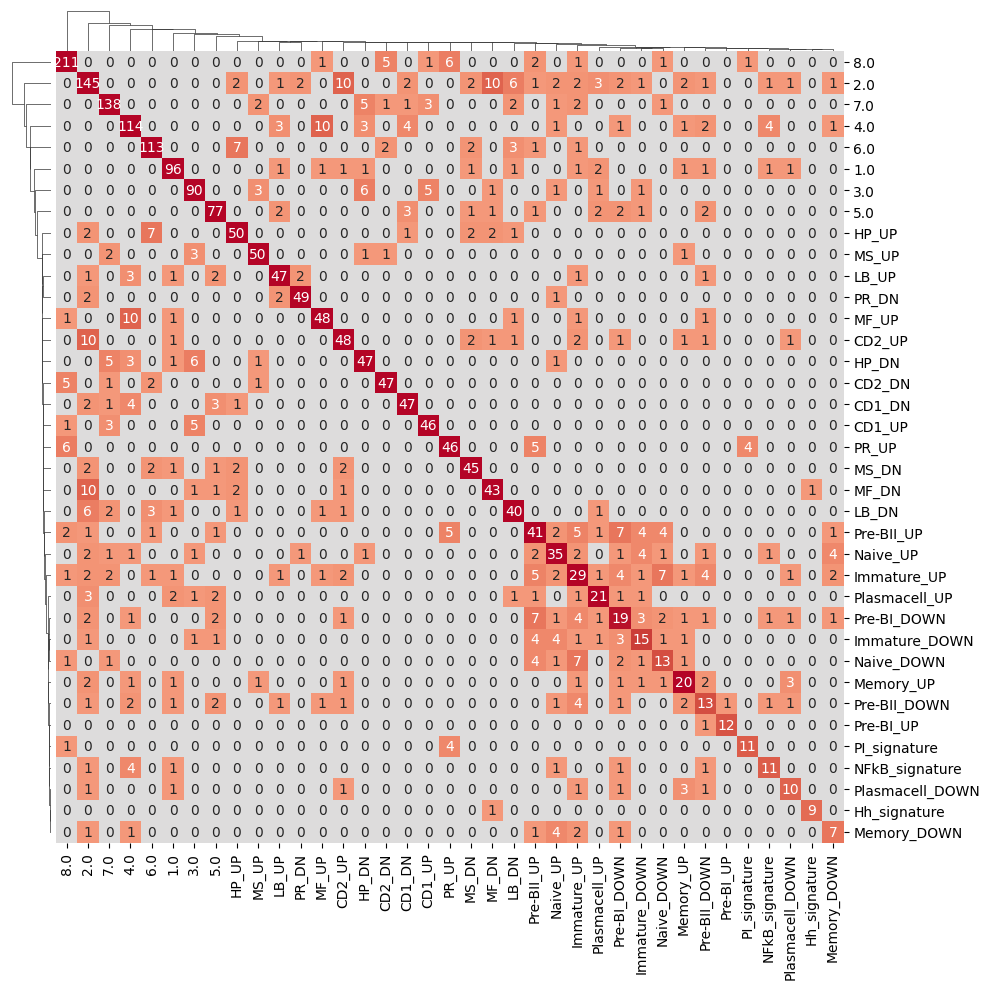

In [67]:
plot_gene_set_intersection(genesets_dict)

In [68]:
genesets_dict.update(new_genesets_arch_dict)

<Figure size 2000x2000 with 0 Axes>

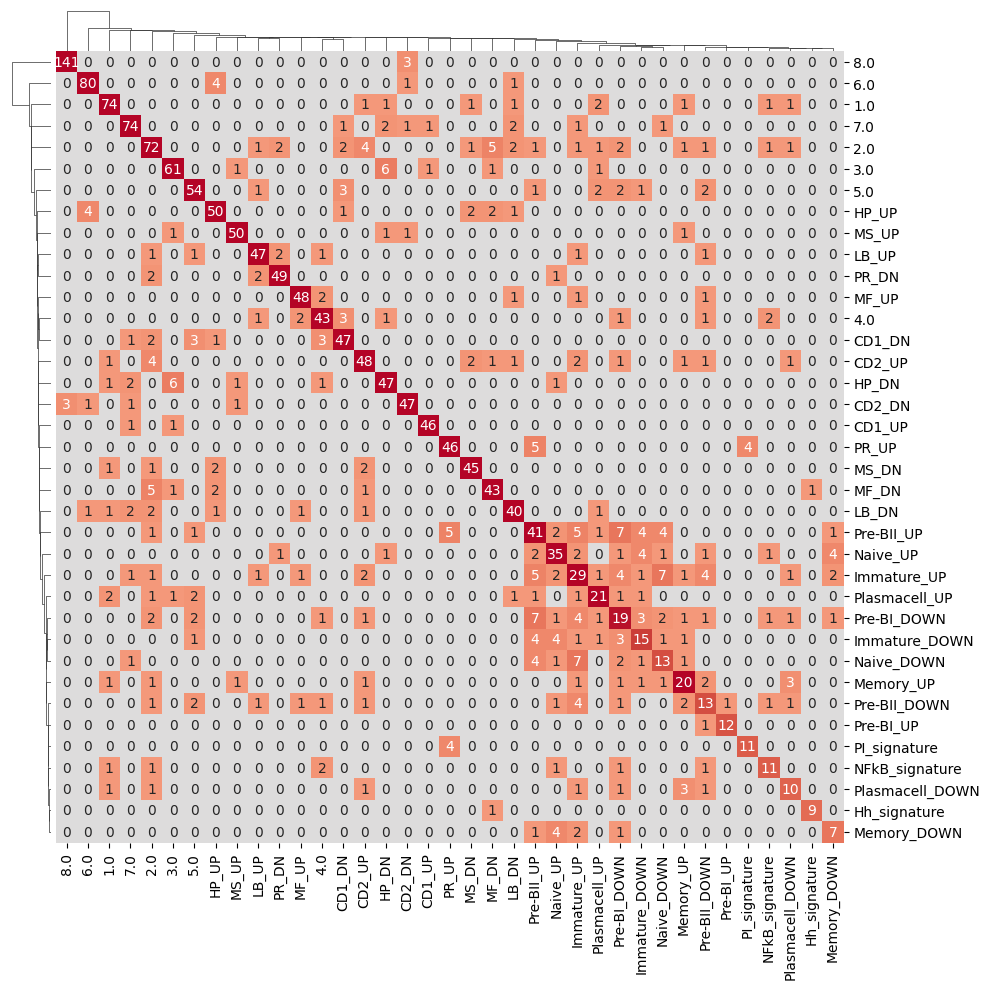

In [69]:
plot_gene_set_intersection(genesets_dict)

### infer geneset scores for archytypes

In [114]:
version = '20240619'

In [115]:
exp = pd.read_csv(os.path.join(data_path, f'exp_pseudobulk_counts_v_{version}.csv'), index_col=0) #counts not log transformed
expr_tpm = pd.read_csv(os.path.join(data_path, f'exp_pseudobulk_tpm_v_{version}.csv'), index_col=0) #tpm not log transformed
ann = pd.read_csv(os.path.join(data_path, f'ann_patient_level_v_{version}.csv'), index_col=0)


In [116]:
def median_scale(data, mask=None, axis=0):
    from statsmodels.robust.scale import mad

    if mask is not None:
        filtered_data = data.reindex(data.index & mask[~mask].index)
    else:
        filtered_data = data

    median_value = 1.0 * filtered_data.median(axis=axis)

    if isinstance(data, pd.Series):
        mad_value = 1.0 * mad(filtered_data.dropna())
        scaled_data = data.sub(median_value).div(mad_value)
    else:
        opposite_axis = (axis + 1) % 2 
        mad_values = 1.0 * filtered_data.apply(lambda x: mad(x.dropna()), axis=axis)
        scaled_data = data.sub(median_value, axis=opposite_axis).div(mad_values, axis=opposite_axis)

    return scaled_data

In [117]:
from single_sample_gsea import ss_gsea

In [118]:
def calculate_signiture_features(genesets, ann, expr_tpm):
    methods = ann['Method'].unique()
    all_features = []
    
    for method in methods:
        method_samples = ann[ann['Method'] == method].index
        exp_tpm_method = expr_tpm.loc[method_samples]
        features = ss_gsea(np.log2(exp_tpm_method + 1).T, genesets)
        features = median_scale(features)
        all_features.append(features)
    
    Features = pd.concat(all_features)
    return Features

Features = calculate_signiture_features(genesets_arch_dict, ann, expr_tpm)
print(Features.shape)
Features.head()

(208, 8)


,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
Sample.Code,,,,,,,,
tlv08_1,-0.246219,-0.409851,0.305470,0.166587,1.720640,-0.469091,0.068709,-0.141866
hmc01_1,0.951241,0.561335,1.347400,0.801569,-0.128523,-1.543213,0.112083,-0.711626
tlv09_1,-0.116524,1.186599,0.774945,0.374997,-0.065510,-0.147333,0.392456,-0.473954
tlv11_1,0.158171,1.062392,-0.163748,0.236128,0.216236,-1.991663,-0.315919,-1.244513
tlv10_1,-0.413912,-0.065518,0.834053,1.143955,1.956569,-1.690512,-0.289358,-1.430100


In [119]:
Features_new = calculate_signiture_features(new_genesets_arch_dict, ann, expr_tpm)
print(Features_new.shape)
Features_new.head()

(208, 8)


,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
Sample.Code,,,,,,,,
tlv08_1,0.688080,-0.431906,0.882718,-0.292822,1.447277,-0.359569,0.199510,-0.137779
hmc01_1,0.832284,0.213121,1.733967,0.897212,0.537301,-1.488925,0.312984,-1.460714
tlv09_1,1.011213,0.857455,0.815139,0.845364,-0.066633,-0.390460,0.402365,-0.753008
tlv11_1,0.486615,1.039046,0.321639,0.757630,0.368710,-1.333313,-0.365045,-1.365982
tlv10_1,1.143973,0.124062,1.209688,1.165537,1.516705,-1.622545,-0.006812,-1.108855


### train and validata classifier on genesets scores

In [132]:
from sklearn.cluster import KMeans

def plot_heatmap(feats, run_kmeans=False, sort_by = 'architype'):
    if run_kmeans:
        kmeans = KMeans(n_clusters=7, random_state=43).fit(feats)
        feats['Cluster'] = kmeans.labels_
        
    if sort_by != 'Cluster':
        indexes_sorted = ann.sort_values(by = sort_by).index
        Features_sorted = feats.loc[indexes_sorted]
    else:
        Features_sorted = feats.sort_values(by='Cluster')

    col_colors_ann = pd.DataFrame({
        'Disease': ann['Disease'].fillna('NA').map(pal_disease),
        'Cyto_Risk': ann['Cyto_Risk'].fillna('NA').map(pal_cytorisk),
        'Method': ann['Method'].fillna('NA').map(pal_method),
        'architype': ann['architype'].fillna('NA').astype(str).map(pal_architype),
        'ISS': ann['ISS'].astype(str).fillna('NA').astype(str).map(pal_iss)
    })

    col_colors = col_colors_ann
    
    print(Features_sorted.min().min())
    print(Features_sorted.max().max())
    
    norm = colors.TwoSlopeNorm(vmin=-3., vcenter=0, vmax=1.5)
    
    sns.clustermap(Features_sorted.T,
                   col_colors=col_colors,
                   figsize=(12, 10),
                   norm = norm,
                   method='ward',
                   #standard_scale=0,
                   metric='euclidean',
                   col_cluster=False, ##
                   row_cluster = True,
                   dendrogram_ratio=(.1, .2), 
                   cmap='coolwarm')
    plt.show()



-4.698112532615979
4.230347660936703


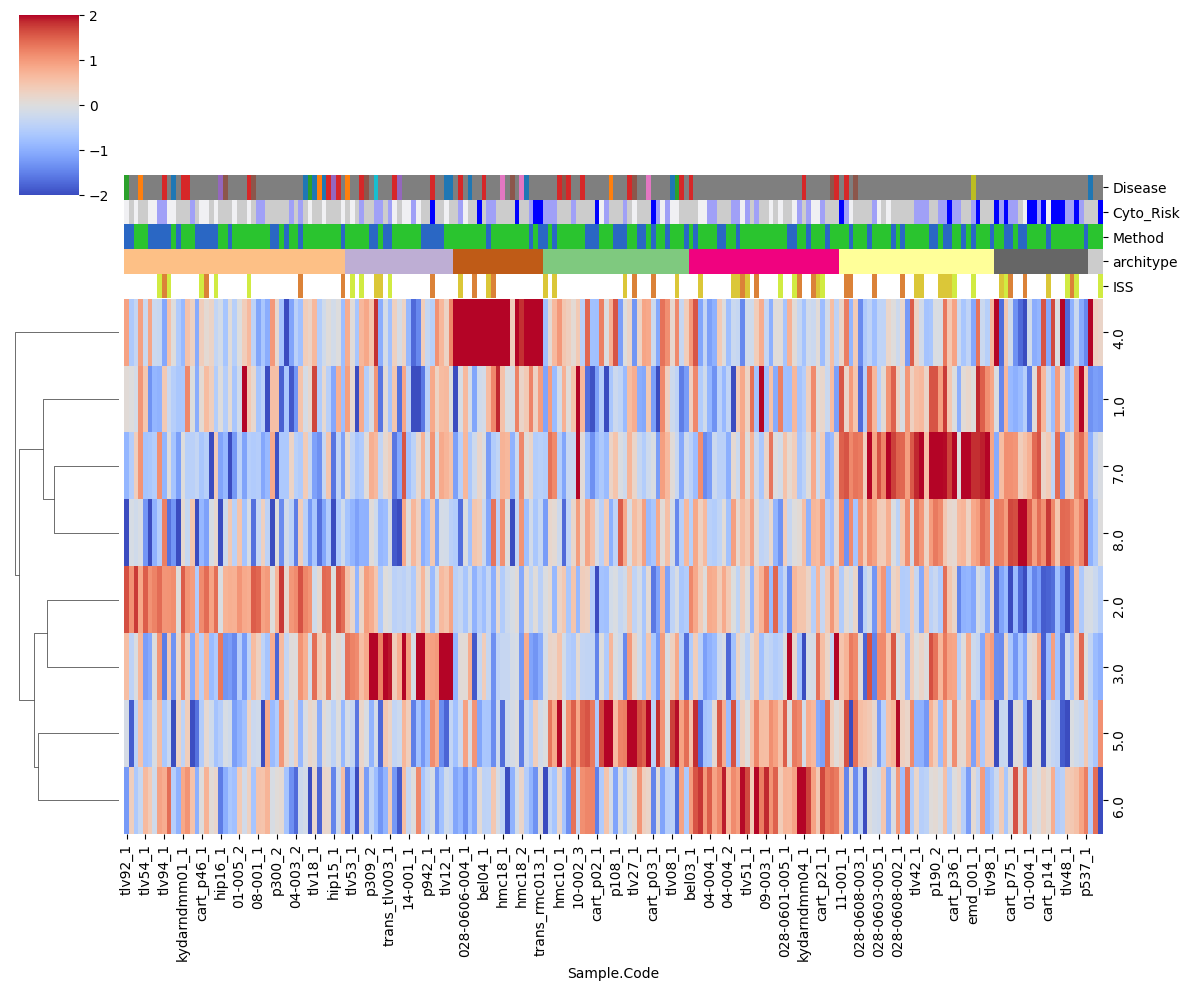

In [130]:
plot_heatmap(Features)

-5.567069908857698
2.2580306034824265


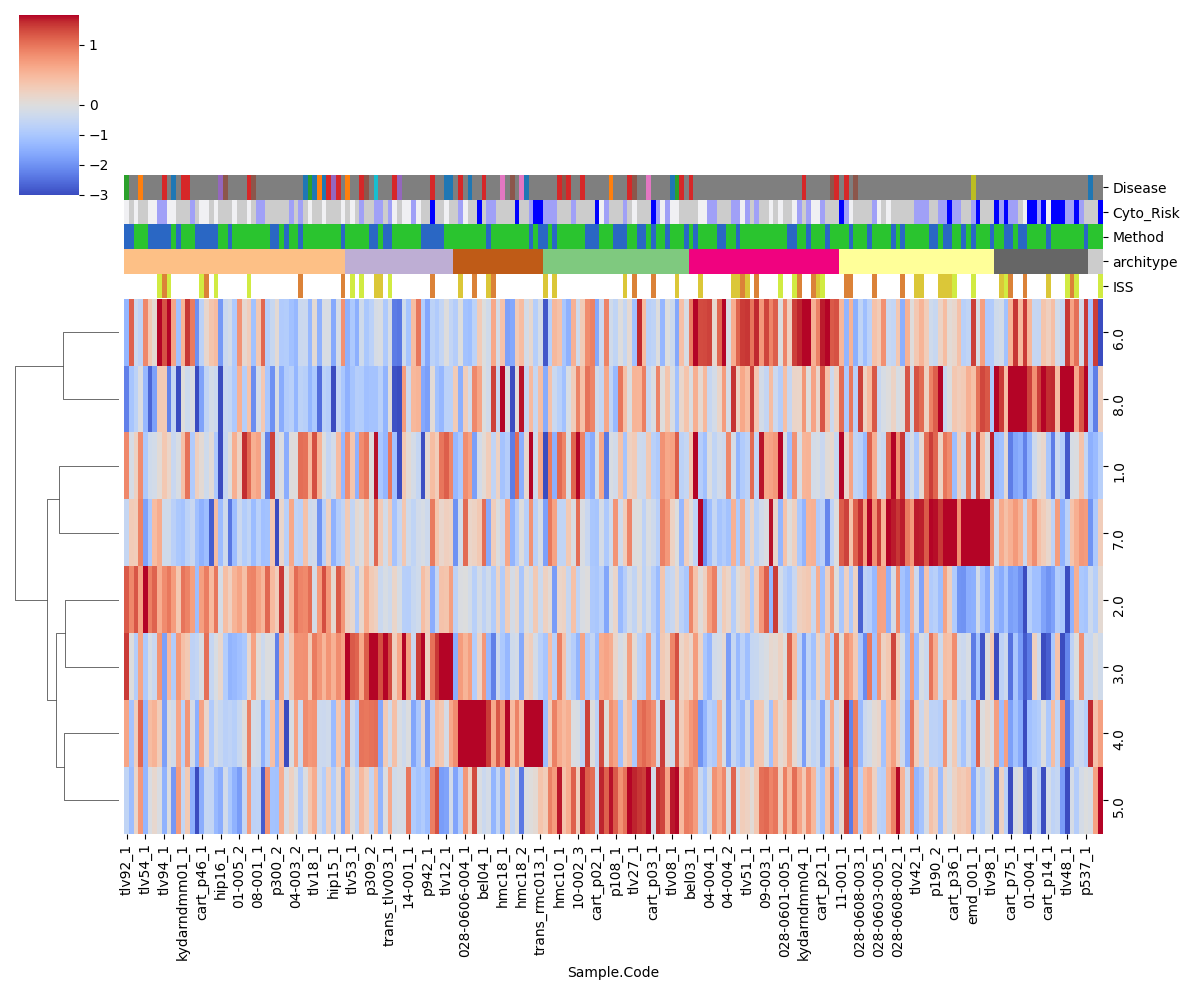

In [133]:
plot_heatmap(Features_new)